# Flight Price Analytics — Wrangling & Quick EDA

**Goal:** build a trustworthy *Buy / Wait* signal from daily route-level fare snapshots.

**Data:**
- Source file: `fares_raw_with_source.(csv|xlsx)`
- Columns: `source_name, origin, destination, search_date, depart_date, price`
- Period: 150+ daily snapshots across 10 routes

**Notebook Outline**
1. Load & inspect raw data  
2. Clean & type-cast dates/prices  
3. Feature engineering: `snapshot_date`, `lead_time_days`, `route`  
4. Dedupe on natural key (route-day)  
5. Quick EDA: price trends, lead-time curves, volatility checks  
6. Save clean fact table → `fares_fact.csv` (and/or Parquet)
   


# 1) Imports & paths

In [1]:
# Loading the dataset using pandas


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSV

RAW = r"D:\MGA\job\data analyst\flight-price-analytics\fares_raw_with_source.csv"
df = pd.read_csv(RAW)          # plus any wrangling you already did



In [2]:
df.head(10)

,source_name,origin,destination,search_date,depart_date,price
0,flight_prices_2025-06-07.csv,NYC,LHR,6/7/2025,8/1/2025,140
1,flight_prices_2025-06-07.csv,NYC,LHR,6/7/2025,8/25/2025,169
2,flight_prices_2025-06-07.csv,NYC,LHR,6/7/2025,8/4/2025,172
3,flight_prices_2025-06-07.csv,NYC,LHR,6/7/2025,7/28/2025,180
4,flight_prices_2025-06-07.csv,NYC,LHR,6/7/2025,7/21/2025,184
5,flight_prices_2025-06-07.csv,NYC,LHR,6/7/2025,7/22/2025,184
6,flight_prices_2025-06-07.csv,NYC,LHR,6/7/2025,7/20/2025,194
7,flight_prices_2025-06-07.csv,NYC,LHR,6/7/2025,7/31/2025,194
8,flight_prices_2025-06-07.csv,NYC,LHR,6/7/2025,7/17/2025,196
9,flight_prices_2025-06-07.csv,NYC,DXB,6/7/2025,9/10/2025,270


In [3]:
df.describe()

,price
count,133775.000000
mean,287.016236
std,152.237835
min,10.000000
25%,171.000000
50%,274.000000
75%,399.000000
max,1612.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133775 entries, 0 to 133774
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   source_name  133775 non-null  object
 1   origin       133775 non-null  object
 2   destination  133775 non-null  object
 3   search_date  133775 non-null  object
 4   depart_date  133775 non-null  object
 5   price        133775 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 6.1+ MB


In [5]:
df.isnull().sum()

source_name    0
origin         0
destination    0
search_date    0
depart_date    0
price          0
dtype: int64

# 2) Type fixes & new columns

In [6]:
import re
from pathlib import Path
import pandas as pd
import numpy as np

# ---- convert types
df["price"] = pd.to_numeric(df["price"], errors="coerce")

for c in ["search_date","depart_date"]:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# ---- snapshot_date from file name: flight_prices_YYYY-MM-DD.csv
snap = df["source_name"].str.extract(r"(\d{4}-\d{2}-\d{2})", expand=False)
df["snapshot_date"] = pd.to_datetime(snap, errors="coerce")

# ---- route (helpful in visuals and grouping)
df["route"] = df["origin"].str.upper().str.strip() + "-" + df["destination"].str.upper().str.strip()

# ---- lead time in days
df["lead_time_days"] = (df["depart_date"] - df["search_date"]).dt.days.astype("Int64")

df.head()


,source_name,origin,destination,search_date,depart_date,price,snapshot_date,route,lead_time_days
0,flight_prices_2025-06-07.csv,NYC,LHR,2025-06-07,2025-08-01,140,2025-06-07,NYC-LHR,55
1,flight_prices_2025-06-07.csv,NYC,LHR,2025-06-07,2025-08-25,169,2025-06-07,NYC-LHR,79
2,flight_prices_2025-06-07.csv,NYC,LHR,2025-06-07,2025-08-04,172,2025-06-07,NYC-LHR,58
3,flight_prices_2025-06-07.csv,NYC,LHR,2025-06-07,2025-07-28,180,2025-06-07,NYC-LHR,51
4,flight_prices_2025-06-07.csv,NYC,LHR,2025-06-07,2025-07-21,184,2025-06-07,NYC-LHR,44


# 3) Quick QA (nulls, ranges, duplicates)

In [7]:
# What’s missing?
df.isna().sum()

# Basic sanity checks
print("min search:", df["search_date"].min(), "max search:", df["search_date"].max())
print("min depart:", df["depart_date"].min(), "max depart:", df["depart_date"].max())
print("min price:", df["price"].min(), "max price:", df["price"].max())
print("lead_time_days min/max:", df["lead_time_days"].min(), df["lead_time_days"].max())

# Remove exact dupes on the natural key (one fare per route/day/snapshot)
key = ["origin","destination","search_date","depart_date","snapshot_date","price"]
before = len(df)
df = df.drop_duplicates(subset=key)
after = len(df)
print(f"Removed {before-after:,} exact duplicates")


min search: 2025-06-07 00:00:00 max search: 2025-11-09 00:00:00
min depart: 2025-06-08 00:00:00 max depart: 2026-02-17 00:00:00
min price: 10 max price: 1612
lead_time_days min/max: 0 100
Removed 0 exact duplicates


# 4) Quick EDA

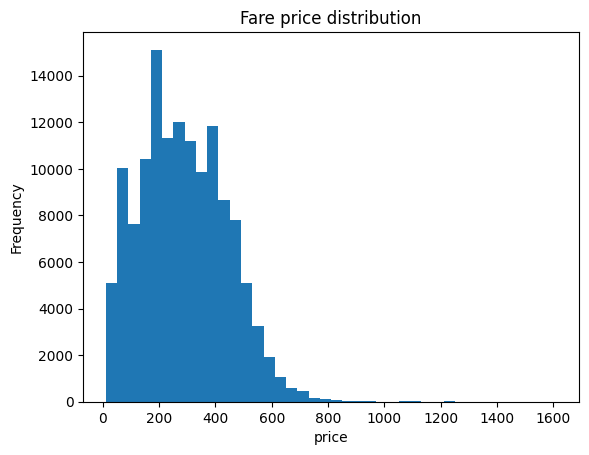

In [9]:
import matplotlib.pyplot as plt

# Price distribution
df["price"].plot(kind="hist", bins=40, title="Fare price distribution")
plt.xlabel("price"); plt.show()

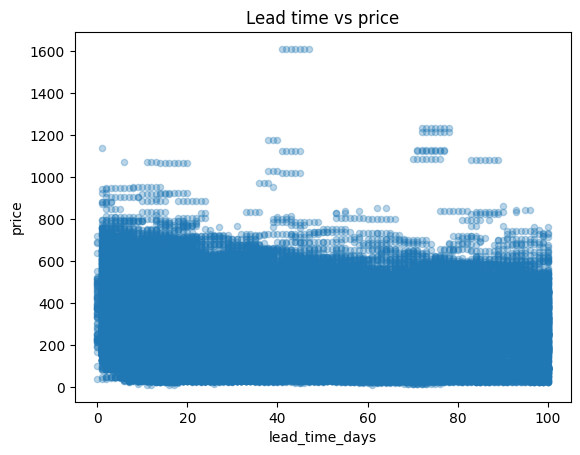

In [10]:

# Lead-time vs price (all routes)
df.plot(kind="scatter", x="lead_time_days", y="price", alpha=0.3, title="Lead time vs price")
plt.show()

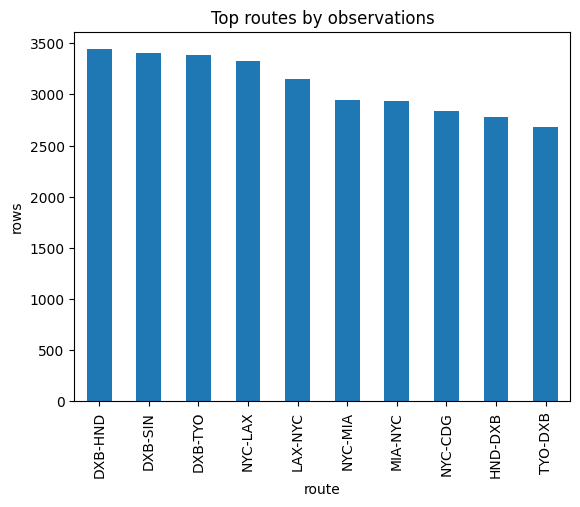

In [11]:
# Top 10 routes by row count
(df["route"].value_counts().head(10)
   .plot(kind="bar", title="Top routes by observations"))
plt.ylabel("rows"); plt.show()


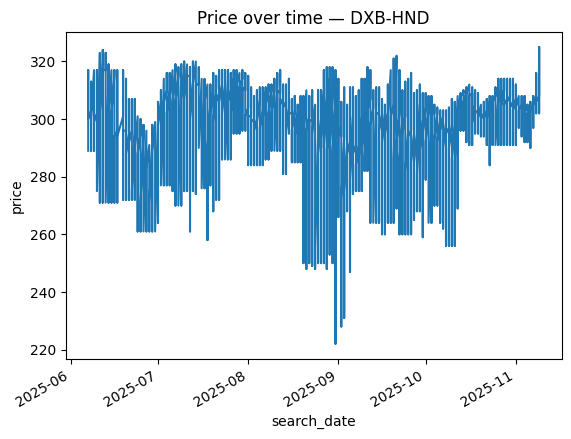

In [12]:
# Example route trend (pick one with many observations)
route_example = df["route"].value_counts().index[0]
df[df["route"]==route_example].sort_values("search_date") \
  .set_index("search_date")["price"] \
  .plot(title=f"Price over time — {route_example}")
plt.ylabel("price"); plt.show()

# 5) Save the clean fact table

In [13]:
# Set output folder/filenames

DATA_DIR = Path(r"D:\MGA\job\data analyst\flight-price-analytics")
OUT_CSV  = DATA_DIR / "fares_fact.csv"
OUT_PARQ = DATA_DIR / "fares_fact.parquet"

df.to_csv(OUT_CSV, index=False)
try:
    df.to_parquet(OUT_PARQ, index=False)   # smaller & faster to reload (optional)
except Exception as e:
    print("Parquet save skipped:", e)

len(df), df.columns.tolist()

(133775,
 ['source_name',
  'origin',
  'destination',
  'search_date',
  'depart_date',
  'price',
  'snapshot_date',
  'route',
  'lead_time_days'])

# Connecting Python script to PostgreSQL

In [14]:
!pip install psycopg2-binary sqlalchemy

  Using cached psycopg2_binary-2.9.11-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
Using cached psycopg2_binary-2.9.11-cp311-cp311-win_amd64.whl (2.7 MB)


In [15]:
from sqlalchemy import create_engine

# Step 1: Connect to PostgreSQL
# Replace placeholders with your actual details
username = "postgres"      # default user
password = "postdata123" # the password you set during installation
host = "localhost"         # if running locally
port = "5432"              # default PostgreSQL port
database = "flight_price_analytics" # the database you created in pgAdmin

engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}")

# Step 2: Load DataFrame into PostgreSQL
table_name = "fares_fact"   # choose any table name
df.to_sql(table_name, engine, if_exists="replace", index=False)

print(f"Data successfully loaded into table '{table_name}' in database '{database}'.")

Data successfully loaded into table 'fares_fact' in database 'flight_price_analytics'.
